In [130]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

### Survey Clean file, creating white/black lists

In [131]:
# Read it in
path = "surveys_clean.csv"
df = pd.read_csv(path, na_filter=False)

# Drop unnecessary columns
df.drop(columns=['ind_id', 'subject_id', 'image_name', 'image_name_2', 'index','outfits','outfits_comment'], inplace=True)

has_data = df['long']!=''
newDF = df[has_data]
newDF.shape

(5404, 2)

In [132]:
whiteDF = newDF[newDF['racial_group'] == 'white']['long']
blackDF = newDF[newDF['racial_group'] == 'black']['long']

whiteList = whiteDF.tolist()
blackList = blackDF.tolist()

In [133]:
whiteList[:5]

['i have no comments.',
 'to maney questions a like in the last here.  the rest alright overseas across',
 "why don't a soldiers have the right to take up any kind of work they want in the army.",
 'good thing if higher authorities get some action on this problems.',
 'some question overlap others and you might think i just checked them to get finished but i checked them as i feel.']

In [134]:
blackDF.head()

0    negro have been told many times they're fighti...
1    i dont like the army. i had rather be on the o...
2    i think that if were going to win this war, th...
3    why is it that the negro dont have the the rig...
4    i highly approve of this questionnaire it give...
Name: long, dtype: object

### DEIM-CUR functions

In [135]:
def cur(A, idx=False, SVD=None, rank=None):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    if rank==None:
        rank = np.linalg.matrix_rank(A)
    
    V,S,Wt = SVD
    
    def DEIM(M): # row/column selection
        p = []
        p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(1,rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p
    
    p_C = DEIM(np.transpose(Wt))
    C = A[:,p_C]
    
    p_R = DEIM(V)
    R = A[p_R]
    
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    
    return (C,U,R, p_C, p_R) if idx else (C,U,R)

In [136]:
embed_white = (model.encode(whiteList))
embed_black = (model.encode(blackList))

### Top Responses for black respondents 

In [137]:
C_black,U_black,R_black, p_C_black, p_R_black = cur(np.transpose(embed_black), idx=True)

In [138]:
print("Black\n")
for i in range(20):
    print(blackList[p_C_black[i]])

Black

if the negro soldier is good enough to participate in the tough & rough army to help our country why not have privileges as same as the white man. since we are considered rotten & no good, we shouldn't't have to fight. we realize this is a white man's country but we are willing to fight for it because we live in it. therefore after this war i hope every negro will take this matter into consideration and force less segregation & a fair living as white people have. if all negro were like me things would be a hell of a lot better  site worse. we must show the white man we are all men together before we shall have equal rights. a man is a man no matter what race, creed or color, so why not be treated alike.
i think this questionnaire is good for us.
i don't like army in any way
i want to make more money to take care of my wife and get out the army so i can take care of her and my to kids
we don't get much to eat and we can't get attention our doctors when we are sick, the no  office

### Top Responses for white respondents 

In [139]:
 C_white,U_white,R_white, p_C_white, p_R_white = cur(np.transpose(embed_white), idx=True)

In [140]:
print("\nWhite\n")
for i in range(20):
    print(whiteList[p_C_white[i]])


White

in my opinion, the army life is alright. civilians treat us fairly good. i am contented because the boys in our outfit are just like brothers. we all complain as a whole. our officers and men are shifted so much we don't have chance to learn much. men are in our outfit who shouldn't't be here. they only hinder us. to many men kiss asses for their rating, while other, less conservative men who have ability, lose faith in the army and don't give a damn. as a result we have a lot of good men lost in the pile. we have a bunch of gold briggers and ass kissing non-coms, showing off their day old stripes. the officers conduct to many needless inspections, and are shifted around to much to be of any aid to the men under them. only men with brains should run the army. not ones with loud mouths.
i think this questionnaire is a good idea
no comments.
the army is a good place for every man if he is able to be in the army.
i would rather be home i could do more good on relief work.
why all 

## Eigenvalue Graphs (White)

In [141]:
embed = np.transpose(embed_white)
first = pd.DataFrame({'Response': whiteList, 'Embedding': embed_white})
second = pd.DataFrame({'Response': whiteList})

In [142]:
for i in range(0, 768):
    x = []
    for j in range(0, len(embed_white)):
        x.append(first['Embedding'][j][i])
    second['x'+str(i)] = x
    
second.iloc[:,1:]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x758,x759,x760,x761,x762,x763,x764,x765,x766,x767
0,0.758591,0.456631,1.158288,-0.455719,-0.180095,1.283310,0.706048,0.358347,-0.999309,0.344630,...,-0.227195,0.462643,0.086750,-0.168338,-0.294847,-0.733800,-0.064139,1.485314,-0.084078,0.013112
1,0.454678,-0.536229,0.779319,0.193302,-0.092970,-0.065367,-0.889141,-0.867361,-0.364727,-0.262388,...,-0.091493,0.120037,0.284678,0.080229,-0.299972,-0.035708,-0.416625,0.467714,-0.377875,0.374595
2,0.422178,0.610620,-0.317593,0.041234,0.122884,0.505356,1.233452,0.438452,-0.306385,-0.208844,...,-0.180563,0.463026,1.149110,-1.301010,-1.116768,0.115643,-0.163776,0.072889,-0.872556,0.422105
3,-0.170448,-0.680924,1.901574,0.523110,-0.252908,-0.436074,0.231396,-0.113363,-0.252537,-0.799451,...,-0.771372,-0.200827,0.274970,-1.376745,-0.996408,-0.065467,-0.677858,-0.443991,-0.864252,-0.829374
4,0.549441,-0.032283,0.780587,0.240238,-0.428685,-0.063074,0.501355,-0.903985,0.004191,0.049287,...,-0.264759,0.058556,-0.114252,-1.299849,-0.530832,-0.343054,-0.306447,0.633780,-0.793164,0.330236
5,0.004660,-0.301120,0.862109,0.273910,-0.373713,-0.793335,0.772640,0.344798,1.541640,-0.659954,...,0.481832,-0.242059,0.569427,-0.937235,-0.681376,0.322259,-0.742309,-1.169469,0.090096,-0.443329
6,0.799952,0.370300,0.983754,-0.038101,0.426844,-1.270377,0.507401,-1.155068,0.053498,-0.916051,...,-0.162250,-0.737028,0.351942,-0.329651,-0.667495,0.348835,0.448731,0.669346,-0.273538,0.238912
7,-0.467367,1.090383,0.241329,0.144277,-0.339844,0.133298,1.658487,-0.429531,0.158903,-0.426430,...,-0.545814,0.268780,0.433029,-1.372047,-0.123898,-0.303350,-0.207291,0.454587,-0.184143,0.317297
8,0.183044,0.378289,-0.555193,0.195641,-0.400503,-0.059412,0.462276,0.128860,0.248229,-0.508374,...,-0.264521,-0.213790,-0.251426,-0.980537,-0.020352,0.232479,-0.071722,0.376107,0.068536,-0.074467
9,0.025188,0.245247,0.461903,0.159790,-0.337907,-0.568613,1.127125,-0.481804,0.568213,-0.414370,...,-0.470136,0.090522,0.232810,-1.411538,0.170678,-0.009579,0.213635,0.184214,-0.486043,0.871293


In [149]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=second.iloc[:,1:], nn=8)

In [150]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)
np.unique(np.imag(eigenvals))

array([0.])

In [151]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [152]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=1), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 1.4142135625218268
Max Norm: 44.22668877499196


In [153]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

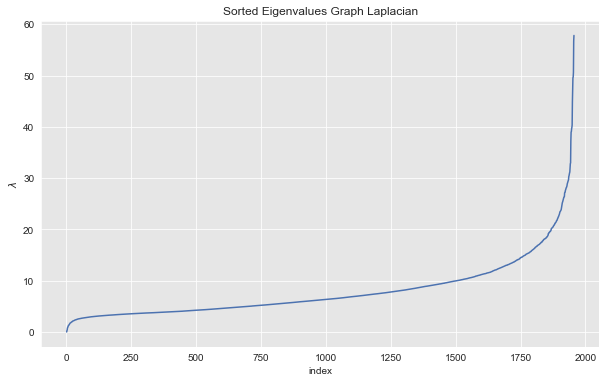

In [154]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

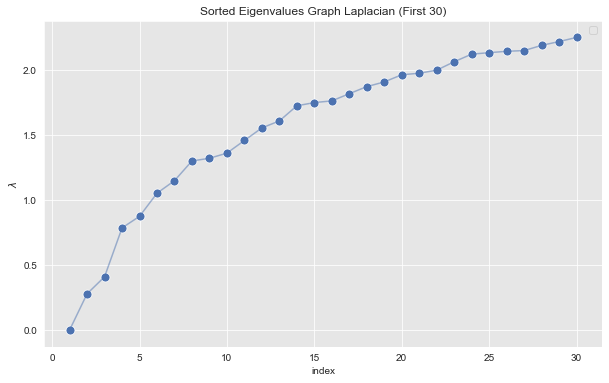

In [155]:
index_lim = 30

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
# ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

## Spectral Clustering on White respondents 

In [156]:
n=3

from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=n,affinity='nearest_neighbors').fit(second.iloc[:, 1:])
first['Cluster'] = [i for i in spectral.labels_]
first['bag'] = first.Response.map(lambda t:t.replace(';','').lower().split())

In [157]:
first.head()

,Response,Embedding,Cluster,bag
0,i have no comments.,"[0.758591, 0.45663133, 1.1582876, -0.45571896,...",2,"[i, have, no, comments.]"
1,to maney questions a like in the last here. t...,"[0.4546784, -0.5362293, 0.7793191, 0.19330154,...",0,"[to, maney, questions, a, like, in, the, last,..."
2,why don't a soldiers have the right to take up...,"[0.42217788, 0.6106196, -0.317593, 0.04123385,...",0,"[why, don't, a, soldiers, have, the, right, to..."
3,good thing if higher authorities get some acti...,"[-0.17044759, -0.6809244, 1.9015743, 0.5231100...",0,"[good, thing, if, higher, authorities, get, so..."
4,some question overlap others and you might thi...,"[0.549441, -0.032282595, 0.780587, 0.24023785,...",0,"[some, question, overlap, others, and, you, mi..."


In [158]:
whiteClusters = first
whiteClusters.drop(columns=['bag'], inplace=True)
whiteClusters.head()

,Response,Embedding,Cluster
0,i have no comments.,"[0.758591, 0.45663133, 1.1582876, -0.45571896,...",2
1,to maney questions a like in the last here. t...,"[0.4546784, -0.5362293, 0.7793191, 0.19330154,...",0
2,why don't a soldiers have the right to take up...,"[0.42217788, 0.6106196, -0.317593, 0.04123385,...",0
3,good thing if higher authorities get some acti...,"[-0.17044759, -0.6809244, 1.9015743, 0.5231100...",0
4,some question overlap others and you might thi...,"[0.549441, -0.032282595, 0.780587, 0.24023785,...",0


### Cluster 0 Top Responses

In [159]:
is_0 = first['Cluster'] == 0
cluster_0 = first[is_0]

cluster_0

,Response,Embedding,Cluster
1,to maney questions a like in the last here. t...,"[0.4546784, -0.5362293, 0.7793191, 0.19330154,...",0
2,why don't a soldiers have the right to take up...,"[0.42217788, 0.6106196, -0.317593, 0.04123385,...",0
3,good thing if higher authorities get some acti...,"[-0.17044759, -0.6809244, 1.9015743, 0.5231100...",0
4,some question overlap others and you might thi...,"[0.549441, -0.032282595, 0.780587, 0.24023785,...",0
5,when is the big drive is goning to start. is ...,"[0.004659554, -0.30111957, 0.8621086, 0.273910...",0
6,i think some types of services in the various ...,"[0.7999524, 0.3702998, 0.9837537, -0.038100604...",0
7,in reference to question #25 there is no coope...,"[-0.4673673, 1.0903834, 0.24132901, 0.14427656...",0
8,let's get something done about prosecuting the...,"[0.18304382, 0.37828875, -0.5551928, 0.1956413...",0
9,i am not fighting to give freedom to the world...,"[0.02518781, 0.24524716, 0.4619027, 0.15978968...",0
10,i want to say that i consider all my efforts i...,"[0.33428708, 0.013279631, 0.61966, 0.085011646...",0


In [160]:
cluster0List = cluster_0['Response'].tolist()

In [161]:
embed0 = np.transpose(model.encode(cluster0List))

In [162]:
C_0,U_0,R_0, p_C_0, p_R_0 = cur(embed0, idx=True)

In [163]:
print("Cluster 0\n")
for i in range(20):
    print(i,':', whiteList[p_C_0[i]],'\n')

Cluster 0

0 : the army is o.k. but once a fellow is given a rotten deal, he is forgotten and pushed around and must hand shake his way to get a half decent break. at present, morale very low. the army is okay but once a fellow is given a rotten deal, he is forgotten and pushed around and must hand-shake his way to get a half decent break. at present, morale very low. 

1 : i think the questions were fair and easy and it gives everybody and idea what the solider about everything right now. 

2 : the question that dealt with asking the president three questions i would like to go oversea instead of staying here i realize my job in the army has it purpose in winning the war but i joined to army to see action and go across. i hope that this day will come soon. 

3 : any soldier who has received specialized training when assigned to an outfit you be entitled to a rating. where i am now you have to belong to a clan or an organization to get a rating. my ideas of officers and non-coms are fe

### Cluster 1 Top Responses

In [164]:
is_1 = first['Cluster'] == 1
cluster_1 = first[is_1]
cluster1List = cluster_1['Response'].tolist()

In [165]:
embed1 = np.transpose(model.encode(cluster1List))

In [166]:
C_1,U_1,R_1, p_C_1, p_R_1 = cur(embed1, idx=True)

In [167]:
print("Cluster 1\n")
for i in range(20):
    if(i<len(p_C_1)):
        print(i,':', whiteList[p_C_1[i]],'\n')

Cluster 1

0 : there is to many non-commission officers what don't know their stuff in our outfit. and all they know is what little that is in the book 21-100. and books will not win this war. we have to many young officers that doesn't know what they are doing. we have to many young boys here. and a lot of old men. that could do more out in civilian life. i was born and raised on a farm. you can always take the boy from the country, but you can't take the country out of the boy. 

1 : the men are to much on the ups and down, the men from the south want to be everything and the men from the north want everything, some non-coms don't have the brain for a good private and they hold cpl. & sgts. ratings. why don't the officers help their men i mean come part of them instead of acting better, at times they won't even talk to a man.  the food is this outfit is poor, i think the food is o.k. but oh boy those cooks, the men hate the goats fed to them 4 times a weeks & beans 5 the coffee is li

In [168]:
cluster_1

,Response,Embedding,Cluster
20,i think its a good idea it shows the opinion o...,"[0.2037903, -0.10202645, 0.8782713, 0.15107334...",1
21,only that they be not wasted.,"[0.4881221, -0.41395187, 1.2548356, 0.08054922...",1
34,i think it is all right to have one of them on...,"[0.04066646, 0.1017818, 1.5416675, 0.08879261,...",1
62,i think its a very good idea to get different ...,"[-0.550942, -0.16477785, 0.77742714, 0.2944586...",1
75,if i will help conditions is ok.,"[0.23020685, 0.0188639, 1.47775, -0.124443516,...",1
89,well to my thought the on all (ok).,"[0.06700678, 0.3238218, 2.1263387, -0.05748607...",1
122,i think this questionnaire is a very good idea.,"[-0.64256024, -0.13728458, 0.7730657, -0.23540...",1
123,it is a very good questionnaire and covers the...,"[-0.7635775, -0.6092535, 0.98413086, 0.1057052...",1
131,most of the questions are pretty fair and you ...,"[-0.17210624, -0.23916717, 0.1112266, 0.361978...",1
139,i believe that this questionnaire is a good id...,"[-0.29047522, -0.12296759, 0.6660496, 0.310604...",1


### Cluster 2 Top Responses

In [169]:
is_2 = first['Cluster'] == 2
cluster_2 = first[is_2]
cluster2List = cluster_2['Response'].tolist()

In [170]:
embed2 = np.transpose(model.encode(cluster2List))

In [171]:
C_2,U_2,R_2, p_C_2, p_R_2 = cur(embed2, idx=True)

In [172]:
print("Cluster 2\n")
for i in range(20):
    if(i<len(p_C_2)):
        print(i,':', whiteList[p_C_2[i]],'\n')

Cluster 2

0 : why don't a soldiers have the right to take up any kind of work they want in the army. 

1 : some question overlap others and you might think i just checked them to get finished but i checked them as i feel. 

2 : i think some types of services in the various branches of service should have a broader training in their work such as radio operators in the field artillery. 

3 : to maney questions a like in the last here.  the rest alright overseas across 

4 : about the two lines in front page dr not put name m.a.s.n. that don't spell much. if you want to find out who the man i think you can do so by checking all the questions. 

5 : white & negro soldiers could not live together 

6 : this whole army works the same as a political machine. that is, those who have the influence have the best jobs, while those without are given all the dirty work to do. most of the officers never seem to forget something which an enlisted man has done wrong and they will always punish him a 

## Eigenvalue Graph (Black)

In [173]:
embed = np.transpose(embed_black)
first = pd.DataFrame({'Response': blackList, 'Embedding': embed_black})
second = pd.DataFrame({'Response': blackList})

In [174]:
for i in range(0, 768):
    x = []
    for j in range(0, len(embed_black)):
        x.append(first['Embedding'][j][i])
    second['x'+str(i)] = x
    
second.iloc[:,1:]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x758,x759,x760,x761,x762,x763,x764,x765,x766,x767
0,-0.431953,-0.633117,-0.260997,0.415460,-0.237683,0.366318,0.100023,-0.451081,0.052305,-0.772222,...,-0.642631,0.836087,-0.149190,-1.482470,-0.134439,-0.003614,-0.635169,0.017464,-0.421150,0.702712
1,-0.214992,0.580386,0.443751,0.505816,-0.749663,-0.185046,0.921740,-0.230475,0.477832,-0.794905,...,-0.089814,0.691420,0.742551,-1.448567,-0.545186,0.429773,-0.311271,0.444563,-0.531232,0.895420
2,-0.221185,-0.399868,-0.199939,0.446165,-0.415950,0.128538,0.631262,-0.336796,-0.060227,-0.329619,...,-1.046082,0.840199,-0.032127,-2.288132,-0.212986,0.444507,-0.337037,-0.118294,-0.242437,0.492241
3,-0.295477,0.572017,-0.411632,0.144846,-0.018772,-0.431764,0.487732,-0.857616,-0.205131,-0.364119,...,-0.130924,0.962862,0.074192,-1.474225,0.079387,0.112434,-0.553907,0.097416,-0.755756,0.560328
4,-0.574096,0.517165,0.017152,0.162733,-0.337314,-0.444252,0.936755,-0.192152,0.711736,-0.574696,...,-0.783802,0.350003,-0.138772,-2.146735,-0.595041,-0.228926,0.669961,0.770852,0.078583,0.114617
5,-0.129600,-0.261325,0.835405,0.506072,0.061220,-0.294037,0.120656,-0.810101,0.435580,-1.011258,...,-0.442945,0.436407,-0.291818,-0.086346,0.090718,-0.196374,-0.844386,-0.142229,-0.793373,0.124300
6,0.705506,0.260656,1.377129,-0.589358,-0.328145,-0.258725,-0.291662,0.063210,-0.334792,-0.747061,...,-0.579069,-0.448920,0.896083,0.289612,-0.295455,0.477540,-0.395083,1.179413,0.365323,0.002767
7,-0.100324,0.106731,-0.172789,-0.011465,0.139848,-0.310977,0.551033,-0.638847,0.252459,-0.805329,...,-0.678320,-0.223613,-1.558329,-1.466871,0.271727,-0.165487,-0.295605,0.819695,-0.286685,0.278997
8,-0.162554,0.039374,0.028283,0.265046,0.288264,0.369567,0.081332,-0.402532,-0.118626,-0.996127,...,-0.384398,0.380285,0.070555,-0.870803,0.246333,-0.137658,-0.602829,0.167117,-0.568393,0.324509
9,0.535083,0.356359,1.297027,-0.067209,0.407620,-0.337240,0.114972,-0.310488,0.436291,0.049877,...,-0.105883,-0.432709,0.637354,-0.878139,-0.101677,0.152479,-0.498487,0.130223,-0.645121,0.334355


In [176]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=second.iloc[:,1:], nn=8)

In [177]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)
np.unique(np.imag(eigenvals))

array([0.])

In [178]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [179]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=1), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 2.5463820878214065
Max Norm: 58.7196730236128


In [180]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

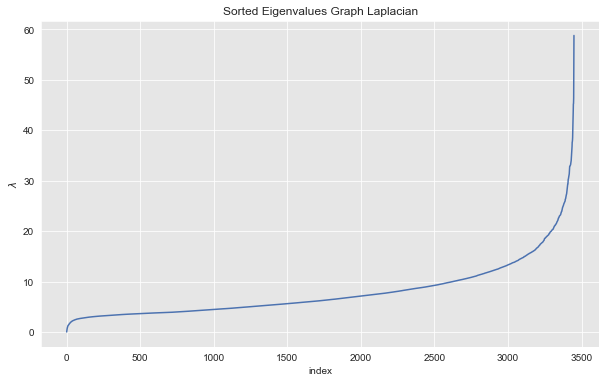

In [181]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

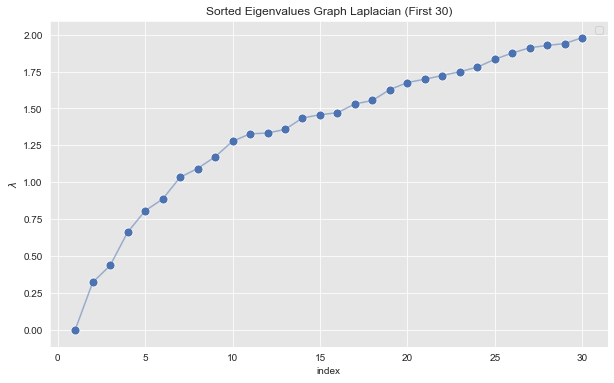

In [182]:
index_lim = 30

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
# ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

### Spectral Clustering on Black Respondents

In [183]:
n=3
spectral = SpectralClustering(n_clusters=n,affinity='nearest_neighbors').fit(second.iloc[:, 1:])
first['Cluster'] = [i for i in spectral.labels_]
first['bag'] = first.Response.map(lambda t:t.replace(';','').lower().split())

In [184]:
first.head()

,Response,Embedding,Cluster,bag
0,negro have been told many times they're fighti...,"[-0.43195295, -0.6331174, -0.26099682, 0.41546...",0,"[negro, have, been, told, many, times, they're..."
1,i dont like the army. i had rather be on the o...,"[-0.21499196, 0.58038604, 0.44375092, 0.505815...",0,"[i, dont, like, the, army., i, had, rather, be..."
2,"i think that if were going to win this war, th...","[-0.22118457, -0.39986774, -0.19993901, 0.4461...",0,"[i, think, that, if, were, going, to, win, thi..."
3,why is it that the negro dont have the the rig...,"[-0.29547727, 0.57201684, -0.41163206, 0.14484...",0,"[why, is, it, that, the, negro, dont, have, th..."
4,i highly approve of this questionnaire it give...,"[-0.57409626, 0.5171654, 0.01715225, 0.1627326...",0,"[i, highly, approve, of, this, questionnaire, ..."


In [185]:
blackClusters = first
blackClusters.drop(columns=['bag'], inplace=True)
blackClusters.head()

,Response,Embedding,Cluster
0,negro have been told many times they're fighti...,"[-0.43195295, -0.6331174, -0.26099682, 0.41546...",0
1,i dont like the army. i had rather be on the o...,"[-0.21499196, 0.58038604, 0.44375092, 0.505815...",0
2,"i think that if were going to win this war, th...","[-0.22118457, -0.39986774, -0.19993901, 0.4461...",0
3,why is it that the negro dont have the the rig...,"[-0.29547727, 0.57201684, -0.41163206, 0.14484...",0
4,i highly approve of this questionnaire it give...,"[-0.57409626, 0.5171654, 0.01715225, 0.1627326...",0


### Cluster 0 Top Responses (Black)

In [186]:
is_0 = first['Cluster'] == 0
cluster_0 = first[is_0]
cluster0List = cluster_0['Response'].tolist()

In [187]:
cluster_0.shape

(3239, 3)

In [188]:
embed0 = np.transpose(model.encode(cluster0List))

In [189]:
C_0,U_0,R_0, p_C_0, p_R_0 = cur(embed0, idx=True)

In [190]:
print("Cluster 0\n")
for i in range(20):
    if(i<len(p_C_0)):
        print(i,':', blackList[p_C_0[i]],'\n')

Cluster 0

0 : my honest opinion is this why should we have to as soldiers in the same army have to believe that just because i am white an he is a negro, feel we cannot eat, dance, sleep, and fight for our country side by side. i believe there are only two slaves left in thsi country they are the white woman and the negro man. the white man and negro woman can do anything they wish. the white man must believe or made to believe the negro doe not want his woman any more then he want his. this makes race  misunderstanding 

1 : i like the army life fine, i think i am being treated right in this war. after the war is over i would like to stay in the army. 

2 : this would be a good national topic for a debate after it get back to washington, inorder that they  could  find out the soldier  about the present war situation. and how many would like to go over sea after  the various question good debate topic for washington 

3 : no it is not a very good idea to have separate px. these soldie

### Cluster 1 Top Responses (Black)

In [191]:
is_1 = first['Cluster'] == 1
cluster_1 = first[is_1]
cluster1List = cluster_1['Response'].tolist()

In [192]:
cluster_1.shape

(26, 3)

In [193]:
embed1 = np.transpose(model.encode(cluster1List))

In [194]:
C_1,U_1,R_1, p_C_1, p_R_1 = cur(embed1, idx=True)

In [195]:
print("Cluster 1\n")
for i in range(20):
    if(i<len(p_C_1)):
        print(i,':', blackList[p_C_1[i]],'\n')

Cluster 1

0 : above all lets stick together and beat the axis as soon as possible so as to get back to normal living again. other problems concerning negro or whites rights should be thrashed out in congress with represen-tation of both races present. 

1 : the infantry is all right but it is to much walking. 

2 : i am a negro soldier i would like very much to get ahead but my phiscal condition will not premit it. but with a little medical attention i could be outfit and able to get ahead but in my present condition i am not outfit for any position in any branch of the armed forces. 

3 : to my idea i do thank as a united  we should come to gather. i am under the same rule and regulation the white man is. and i am human the same as he i have to live just like dose. and we do as a colored race obey the law better than he dose. how would you like for the colored race. two take your mother out and hang her to a tree and beet her to death. are your wife sister brother are farther 

4 : i

### Cluster 2 Top Responses (Black)

In [196]:
is_2 = first['Cluster'] == 2
cluster_2 = first[is_2]
cluster2List = cluster_2['Response'].tolist()

In [197]:
cluster_2.shape

(183, 3)

In [198]:
embed2 = np.transpose(model.encode(cluster2List))

In [199]:
C_2,U_2,R_2, p_C_2, p_R_2 = cur(embed2, idx=True)

In [200]:
print("Cluster 2\n")
for i in range(20):
    if(i<len(p_C_2)):
        print(i,':', blackList[p_C_2[i]],'\n')

Cluster 2

0 : the army's ok and you can send me to  in the morning if you wish to. 

1 : well we dont to fight. but we have to fight and we work hard to fight. i would like to be in all negro outfit and no white at all we like and we cant i due to part well i don't like the army at all 

2 : above all lets stick together and beat the axis as soon as possible so as to get back to normal living again. other problems concerning negro or whites rights should be thrashed out in congress with represen-tation of both races present. 

3 : 1. i hope the war will not last long. 2. and i hope we will win the war. 3. we will win this war. 4. i hope the people back home will work and do there part and help us win this war 5. i hope the farm will raise a pleny food for our shoulder 6. and i hope i will get in a camp in the south 7. i would like to see my people. and also my fiency 8. if we team work together we will win this war. 9. and we are going to win it. 

4 : 22 - reason men dont cooperate i